# Cleaning/EDA/Prepping Data/Sentiment Analysis

This notebook contains cleaning, preprocessing, exploratory analisis and sentiment analysis of my dataset.

## Import Necessary Libraries


In [1]:
import functions as f
import pyforest
import spacy
import re
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokens import Token
from spacy import displacy
nlp = spacy.load("en_core_web_sm")
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS


## Load in the Dataset

In [2]:
df = pd.read_csv("reviews.csv")

<IPython.core.display.Javascript object>

In [3]:
# chekcing for NA values
df.isnull().sum()

Reviews    0
Date       0
Names      0
Tittles    0
dtype: int64

In [4]:
# checking for duplicants
duplicates = df[df.Reviews.duplicated(keep = False)].sort_values(by='Reviews')
df.drop_duplicates(subset=['Reviews'],keep=False,inplace = True)

In [5]:
# remove \n from Reviews and tittles features 
df.Reviews = df.Reviews.str.strip('\n')
df.Tittles = df.Tittles.str.strip('\n')

## EDA 

Text(0.5, 0, 'Review length')

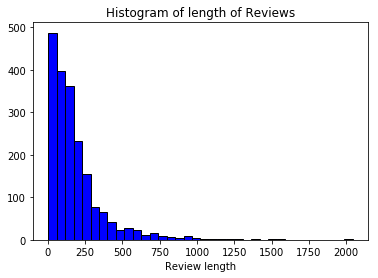

In [6]:
# create a new colum with the len of the reviews
df['Reviews_len'] = df['Reviews'].apply(lambda x :len(x))
plt.hist(df['Reviews_len'], color = 'blue', edgecolor = 'black', bins = int(180/5))
plt.title('Histogram of length of Reviews')
plt.xlabel('Review length')

In [7]:
print('mean:', df.Reviews_len.mean())
print('std:', df.Reviews_len.std())
print('max:', df.Reviews_len.max())
print('min:', df.Reviews_len.min())

mean: 183.88849287169043
std: 196.50345553878964
max: 2043
min: 3


- The average review in the dataframe is roughly 183 characters in length. Taking a generous assumption that the average word is 10 characters in length (this can help account for spaces and punctuation), the average article is roughly 18 words long.

In [8]:
df.Names.value_counts().describe()

count    1692.000000
mean        1.160757
std         4.101771
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       143.000000
Name: Names, dtype: float64

- There are 1692 unique authors in the dataframe which is quite diverse. The average author has contributed about 1 review to the dataframe. The top author has contributed 143 reviews. 

In [9]:
df['Month'] = df['Date'].apply(lambda x: x.split()[0])
df['Month_values'] = df['Month'].value_counts()
df['Month'].value_counts().describe()

count     12.000000
mean     163.666667
std       28.531747
min      117.000000
25%      151.500000
50%      162.000000
75%      171.500000
max      237.000000
Name: Month, dtype: float64

- The average reviews done by month is 163 in this dataframe. The month with most reviews is January and the month with last reviews is April.

## Data Pre-Processing

In [10]:
# removing some of the features that are not going to be heplfull for my model
df = df.drop(['Date', 'Month' , 'Month_values','Reviews_len' ], axis = 1 )

In [11]:
df['Reviews'] = df['Reviews'].apply(lambda x: x.split())

In [12]:
df['Reviews'] = df['Reviews'].apply(lambda x: ' '.join(x))

In [13]:
f.clean_data(df)

,Reviews,Names,Tittles
2,i have used overdrive on my android devices fo...,deborah england,still struggling
3,too many romance novels in literature selecti...,pianogal,this is only reason i downloaded so sorta usel...
4,i have tried to use this app but haven t figur...,dita c batteau,difficult to use
5,i used to be able to drag books from here to ...,d mede,virtual library with limitations
6,it does not seem to have the ability to order ...,amazon customer,annoying steps


In [14]:
# removing words less than 3
df['Reviews'] = df['Reviews'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))


## Tokenize , Remove Stop Words and Lemmatization

In [15]:
added_stopwords = ['thee', 'thing', 'thy', 'ye', 'thou', 'hath']
nlp.Defaults.stop_words |= {'thee', 'thing', 'thy', 'ye', 'thou', 'hath'}

In [16]:
def remove_stop(doc_tokens):
    """removes stop words and returns list of all nonstop words that is lemmatized"""
    return [token.lemma_ for token in doc_tokens if not token.is_stop]

In [17]:
df['Reviews_tokenize'] = df['Reviews'].apply(lambda x: remove_stop(nlp(x)))

In [18]:
df['Reviews_tokenize_join'] = df['Reviews_tokenize'].apply(lambda x: ' '.join(x))

## Frequency words

          word  count
20        book   1403
81     library   1001
107     kindle    741
19    download    639
38        work    569
0    overdrive    388
15        find    336
43        read    334
55        time    307
11        fire    303
51         try    248
129       like    222
10      amazon    202
21        want    175
83   difficult    173
26        need    169
62        able    161
7         user    158
226       easy    158
298      check    156


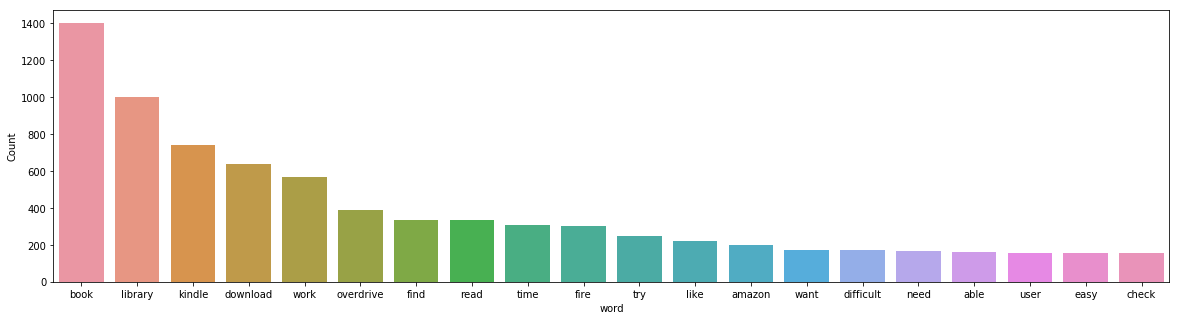

In [19]:
f.words_frequency(df['Reviews_tokenize_join'])

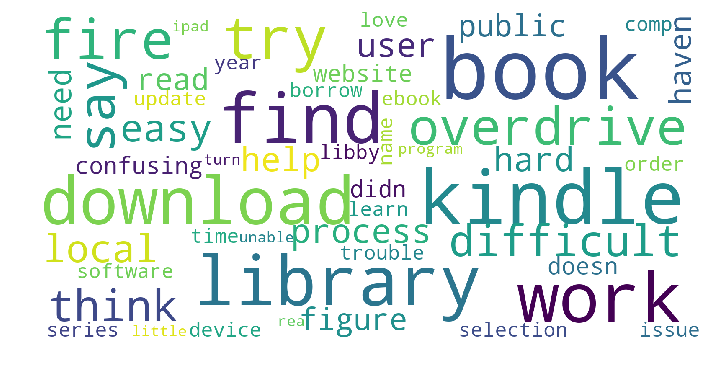

In [20]:
f.show_wordcloud(df['Reviews_tokenize_join'])

## Sentiment Analysis 

I am going to implement sentiment analysis in my dataset. After I will encode positive sentiment as 1 and negative sentiment as 0 so the dataset will have labels for the classification models.

In [21]:
pol = lambda x: TextBlob(x).sentiment.polarity
df['polarity'] = df['Reviews_tokenize_join'].apply(pol)


In [23]:
# create a new feature called label
df['label'] = ['positive' if x > 0  else 'negative' for x in df['polarity']]


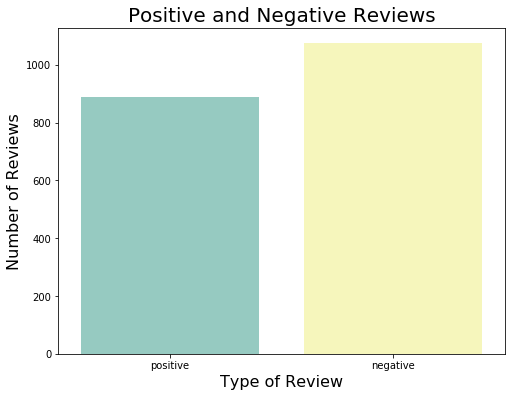

In [26]:
f.plot_binary(df, 'label')

In [27]:
df['label'].value_counts(normalize= True)


negative    0.547352
positive    0.452648
Name: label, dtype: float64

In [28]:
# encode label featture positive as 1 , negative as 0
df['target'] = [1 if i == 'positive' else 0 for i in df['label']]
# create a new df with only the features necesary for my model
df = df.filter(['Reviews_tokenize_join','target'], axis=1)

In [30]:
# save df clean into a new csv
df.to_csv('data_clean', index=False)